# HW Instructions

In this exercise, you will be working with the ViT model for image classification using the CIFAR10 dataset. 

The task will involve going through the full machine learning lifecycle, including: preprocessing and exploratory data analysis, model implementation and training, tuning, and evaluation. 

It is assumed that you have some prior experience in the field from previous assignments. This assignment allows for flexibility in exploring and implementing solutions as you see fit.
Make sure you read the instructions carefully.

In [243]:
# feel free to add any imports you might need (as long as it is part of the course environment)
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.models.vision_transformer import Encoder
import matplotlib.pyplot as plt
import copy
import time
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [244]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
     truck       frog        dog      plane


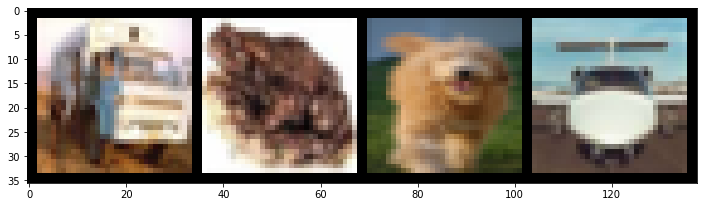

In [245]:
#############################################################################
# TO DO:                                                                    #
# plot a couple of images with their corresponding labels                   #
#############################################################################
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig = plt.figure(figsize=(12,8))
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
inx = np.random.randint(1000, size=4)   
images = train_dataset.data[inx]
labels = np.array(train_dataset.targets)[inx]
images = np.transpose(images, (0, 3, 1,2))
images = torch.tensor(images)
print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## A bit of exploratory data analysis (EDA)

In [246]:
#############################################################################
# TO DO:                                                                    #
# Figure out the size of the dataset:                                       #
# How many samples in train/test?                                            #
# How many labels? How many samples per label?                              #
# Try access train_dataset.__dict__.keys() to see which attributes          #
# are available on train_dataset.                                           #
#############################################################################
print(f"The size of the database: {len(train_dataset) + len(test_dataset)}.")
print(f'There are {len(train_dataset)} samples in the train dataset and {len(test_dataset)} samples in the test dataset.')
print(f'There are {len(train_dataset.classes)} labels in the database.')
dic = {"train": train_dataset, "test": test_dataset}
for set_type, data in dic.items():
    print(f'Number of samples per label for the {set_type} dataset:')
    targets = np.array(data.targets)
    labels, counts = np.unique(targets, return_counts=True)
    print(dict(zip(labels, counts)))
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

The size of the database: 60000.
There are 50000 samples in the train dataset and 10000 samples in the test dataset.
There are 10 labels in the database.
Number of samples per label for the train dataset:
{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Number of samples per label for the test dataset:
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


## Create DataLoaders

In [247]:
#############################################################################
# TO DO:                                                                    #
# Decide on a batch size (which later can be tunned)                        #
#############################################################################
batch_size = 64
# Create a validation set from the training set
valid_size = 0.1
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_size = len(train_dataset) - split
valid_size = split

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

# Building ViT Model

In the next section, you will construct a Vision Transformer, a transformer-based image classifier. The goal of the ViT model is to bring advancements from the natural language processing field to computer vision. 

For this exercise, you will be required to implement the ViT model using a pre-built Encoder from the PyTorch library. Building the encoder can be challenging, so we have eliminated that step for you. If you are not familiar with the ViT model, it is highly recommended that you gain an understanding of its workings before beginning implementation. There is a ton of information available online, here is a pretty informative source:
https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline

In this assignment, you will be using a pre-built Encoder from the PyTorch library, which has already been loaded in the provided code. Therefore, you do not need to worry about the complexities of transformer computations when referring to the link provided.

In [248]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_layers, num_heads, hidden_dim, 
                 mlp_dim, dropout, attention_dropout):
        super().__init__()
        
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the required layers for your ViT model implementation.           #
        # Hint: For the curious among us, you can pick at pytorch's                 #
        # official implemetantion of vit (vit_b_16).                                #
        #############################################################################
        
        self.seq_length = (image_size // patch_size) ** 2
        # initializing the encoder backbone
        # you should calculate the seq_length
        self.encoder = Encoder(
        seq_length=self.seq_length,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
        attention_dropout=attention_dropout
        )
        self.mapper = nn.Linear(3*patch_size**2, hidden_dim)

        self.head = nn.Sequential( 
            nn.Linear(hidden_dim*self.seq_length, hidden_dim),
            nn.BatchNorm1d(hidden_dim, momentum=0.01),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    
        
    
        #############################################################################
        # TO DO:                                                                    #
        # Complete the rest of the class (foward method and other helper            #
        # functions if needed).                                                     #
        #############################################################################
    def forward(self, x):
        x = x.reshape(x.shape[0], self.seq_length, -1)
        x= self.mapper(x)
        x = self.encoder(x)
        x = x.reshape(x.shape[0], -1)
        x = self.head(x)
        return x


        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [249]:
# this is just a simple initialization, feel free to change it.
model = ViT(image_size=32, patch_size=8, num_classes=10, num_layers=2, num_heads=2, hidden_dim=192, 
                 mlp_dim=512, dropout=0.1, attention_dropout=0.1)

# Training

## IMPORTANT READ!

In the following section, you will be required to train your implementation of the ViT model as in previous assignments. However, it is important to note that training transformers can be challenging, especially when starting from scratch, as is the case in this exercise.

It is acceptable if your final model does not achieve a high accuracy score, but it is crucial to document your training experiments and demonstrate that the model is able to train correctly (i.e. the loss decreases over time). This includes noting what you tried, what parameters worked best, and providing the loss and accuracy graphs as instructed in the next sections.

A reference for training ViT on CIFAR10 can be found at https://github.com/omihub777/ViT-CIFAR. However, it's important to note that in the provided reference, the ViT model was trained using 200 epochs and over 2 hours of training.

Note 1: If the loss decreases and your model trains correctly, you are on the safe side. The focus should be on the experiments and the things you tried.

Note 2: The main goal is not to achieve a high accuracy score but to demonstrate that you understand the process.

Note 3: If your final model's performance is strictly better than a random model (accuracy of around 1/num_classes) and you have provided thorough documentation of your experiments and processes, you will receive full credit for the assignment. 

In [250]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    # keep track of training loss
    np.random.seed(10)
    train_loss = 0.0
    train_accuracy = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device, dtype=torch.int64)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        train_loss += loss
        # Calculate Accuracy
        _, predicted = torch.max(output, 1)
        train_accuracy += torch.sum(predicted == target)  
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        optimizer.step()
        
    epoch_loss = train_loss.item() / train_size
    epoch_acc = train_accuracy.item() / train_size
    
    return epoch_loss, epoch_acc

In [251]:
def validate_one_epoch(model, valid_loader, criterion):
    # keep track of validation loss
    np.random.seed(10)
    valid_loss = 0.0
    valid_accuracy = 0.0
    
    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device, dtype=torch.int64)
            
        with torch.no_grad():
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # Calculate Accuracy
            _, predicted = torch.max(output, 1)
            valid_accuracy += torch.sum(predicted == target)   
            # update average validation loss and accuracy
            valid_loss += loss
    epoch_loss = valid_loss.item() / valid_size
    epoch_acc = valid_accuracy.item() / valid_size
    return epoch_loss, epoch_acc

In [252]:
#############################################################################
# TO DO:                                                                    #
# Implement the training loop
# Save the loss and accuracy for both training/validation sets every couple of iterations for plotting afterwards.
#############################################################################
np.random.seed(10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()
best_model_wts = copy.deepcopy(model.state_dict())

epochs = 8
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_acc = 0.0

since = time.time()
for epoch in range(1, epochs + 1):
    print(f"EPOCH {epoch}:")
    train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f'\t[TRAIN] LOSS: {train_loss:.4f}, ACCURACY: {train_acc:.2f}')
    valid_loss, valid_acc = validate_one_epoch(model, validloader, criterion)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    print(f"\t[VALID] LOSS: {valid_loss:.4f}, ACCURACY: {valid_acc:.2f}")
    if valid_acc > best_acc:
        best_acc = valid_acc
        best_model_wts = copy.deepcopy(model.state_dict())
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

EPOCH 1:
	[TRAIN] LOSS: 0.0247, ACCURACY: 0.43
	[VALID] LOSS: 0.0224, ACCURACY: 0.49
EPOCH 2:
	[TRAIN] LOSS: 0.0211, ACCURACY: 0.52
	[VALID] LOSS: 0.0210, ACCURACY: 0.53
EPOCH 3:
	[TRAIN] LOSS: 0.0193, ACCURACY: 0.56
	[VALID] LOSS: 0.0196, ACCURACY: 0.55
EPOCH 4:
	[TRAIN] LOSS: 0.0180, ACCURACY: 0.59
	[VALID] LOSS: 0.0190, ACCURACY: 0.58
EPOCH 5:
	[TRAIN] LOSS: 0.0169, ACCURACY: 0.62
	[VALID] LOSS: 0.0187, ACCURACY: 0.58
EPOCH 6:
	[TRAIN] LOSS: 0.0159, ACCURACY: 0.64
	[VALID] LOSS: 0.0179, ACCURACY: 0.60
EPOCH 7:
	[TRAIN] LOSS: 0.0150, ACCURACY: 0.66
	[VALID] LOSS: 0.0180, ACCURACY: 0.61
EPOCH 8:
	[TRAIN] LOSS: 0.0141, ACCURACY: 0.68
	[VALID] LOSS: 0.0178, ACCURACY: 0.61
Training complete in 1m 30s


## Loss and Acurracy

In [253]:
# Plot 2 graphs:
# Graph 1: Loss vs itreation for training and validation sets
# Graph 2: Accuracy vs itreation for training and validation sets

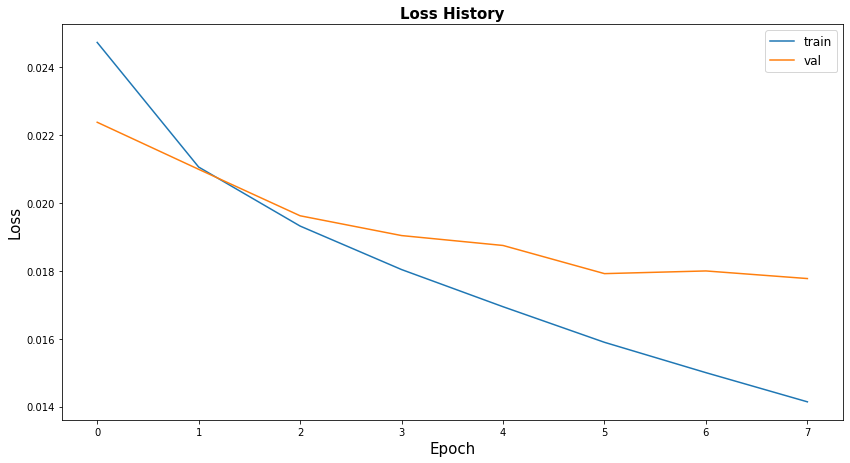

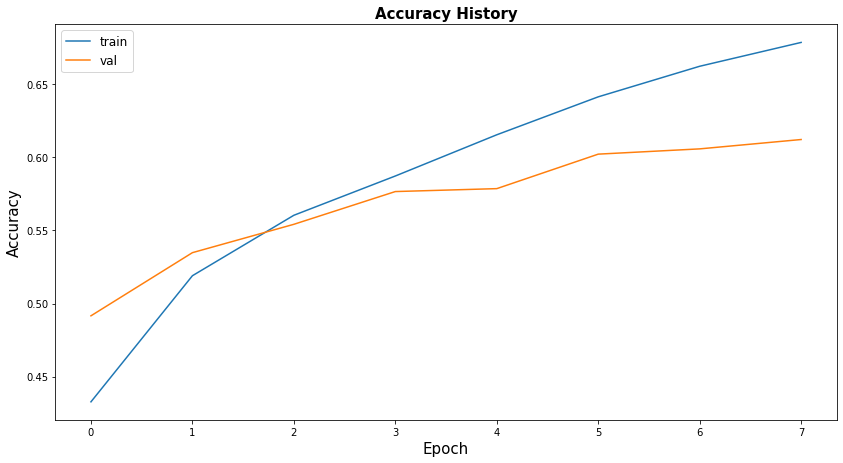

In [254]:
plt.rcParams["figure.figsize"] = (14,16)

def draw_graph(train, val, ylabel, title):
    plt.plot(train, label='train')
    plt.plot(val, label='val')
    plt.title(title, weight='bold', size=15)
    plt.xlabel('Epoch', size=15)
    plt.ylabel(ylabel, size=15)
    plt.legend(fontsize=12)
    plt.show()
    
plt.subplot(2, 1, 1)
draw_graph(train_losses, valid_losses, 'Loss', 'Loss History');
plt.subplot(2, 1, 2)
draw_graph(train_accs, valid_accs, 'Accuracy', 'Accuracy History');

# Evaluation 

In [255]:
# Calculate the accuracy of the final model on the test set.

In [256]:
model.load_state_dict(best_model_wts)
np.random.seed(10)
test_accuracy = 0.0
######################
# test the model #
######################

for data, target in testloader:
    data = data.to(device)
    target = target.to(device, dtype=torch.int64)     
    with torch.no_grad():
        output = model(data)
        _, predicted = torch.max(output, 1)
        test_accuracy += torch.sum(predicted == target)   
    epoch_acc = test_accuracy.item() / len(test_dataset)
print(f"TEST ACCURACY: {epoch_acc :.2f}%")

TEST ACCURACY: 0.62%


# Questions

##**Question:** 

Explain the importance of the positional embedding in the ViT model.

**Your answer:** The position embedding allows the model to understand the relative position of the patches in the image, which is crucial for the model to make a prediction based on the context of the patches. Additionally, The positional embedding also allows the model to process sequences in parallel, which makes training and inference more efficient. 

##**Question:** 

How would you evaluate the model if the number of samples per class would not be balanced?
How can you deal with class imbalance on multiclass classification?

**Your answer:**  
There are several ways to evaluate the model based on imbalanced database:
1. confusion-matrix is good technique to summarizing the performance of a classification algorithm, looking at the confusion matrix one can clearly see how the model is performing on classifying various classes.
2. Using metrics that take into account class imbalance: metrics such as precision, recall, F1-score, area under the ROC curve (AUC-ROC) or area under the precision-recall curve (AUC-PR) are robust to class imbalance.

There are several ways to deal with class imbalance on multiclass classification:

1. **Resampling:** This involves either oversampling the minority class or undersampling the majority class to balance the class distribution.
2. **Cost-sensitive learning:** This involves adjusting the cost function of the classifier to take into account the class imbalance. This can be done by assigning different costs or different weights to misclassifying different classes. This can help to provide some bias towards the minority classes while training the model and thus help in improving performance of the model while classifying various classes.
3. **Data augmentation:** create more sample for minority class by applying different data augmentation techniques such as flipping, rotation, cropping, etc.
